# Sismique onde P : Inversion

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import pygimli as pg
import pygimli.meshtools as mt
import pygimli.physics.traveltime as tt
from pygimli.viewer.mpl import createColorBar, drawMesh, drawModel, createColorBarOnly
from pygimli.frameworks.resolution import resolutionMatrix

In [2]:
data_raw = pg.physics.traveltime.load('data/sgt/data.sgt')
data = data_raw.copy()
print(data)

Data: Sensors: 97 data: 2352, nonzero entries: ['g', 's', 't', 'valid']


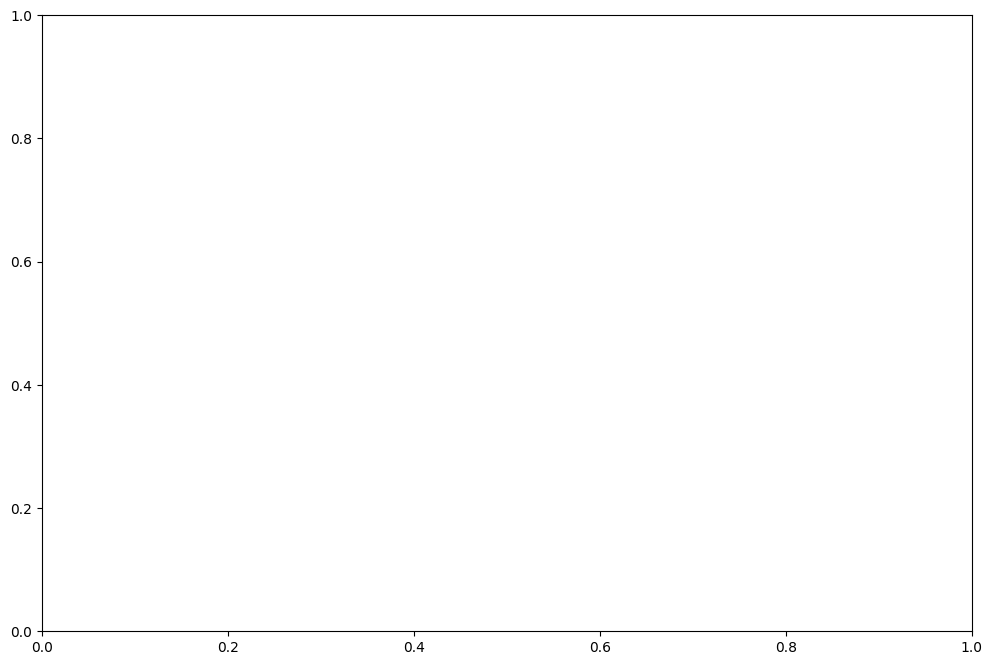

In [3]:
x_shots = np.unique(data['s'])
for k, x_shot in enumerate(x_shots):
    data_shot = data.copy()
    data_shot.remove(data['s'] != x_shot)
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    tt.show(data_shot, ax=ax, marker='+')
    ax.set_xlabel("Х [m]")
    ax.set_ylabel("Temps de trajet [s]")
    ax.set_xlim(np.min(pg.x(data)), np.max(pg.x(data)))
    ax.set_ylim(0.065, -0.005)
    plt.title(f'Shot à {x_shot:.2f} m')
    plt.savefig(f'figures/shot_picks/shot_{k:2d}')
    plt.close()

In [4]:
mgr_raw = tt.TravelTimeManager(data_raw)

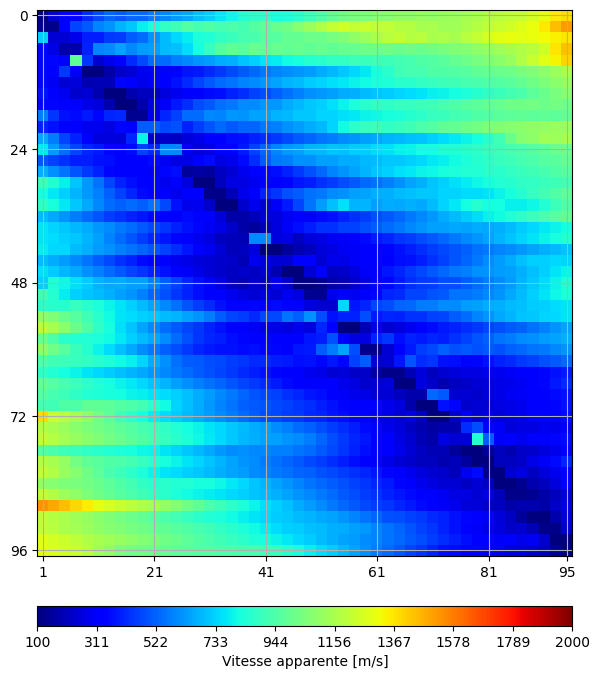

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

ax, cbar = mgr_raw.showData(ax=ax, logScale=False, nLevs=10, cMap='jet',
                        label = 'Vitesse apparente [m/s]',
                        cMin=100, cMax=2000)

In [6]:
dmin = 6
ii = data['t'] < 0
jj = tt.shotReceiverDistances(data) < dmin
data.remove(ii)
data.remove(jj)
print(f'Retire {sum(ii)} pointés de temps négatifs et {sum(jj)} de géophones trop proches du shot soit {data_raw.size() - data.size()}/{data_raw.size()} données')

Retire 0 pointés de temps négatifs et 372 de géophones trop proches du shot soit 372/2352 données


In [7]:
mgr = tt.TravelTimeManager(data)

errLevel = 0.03
data['err'] = mgr.estimateError(data['t'], errLevel=errLevel, absError=1e-9)

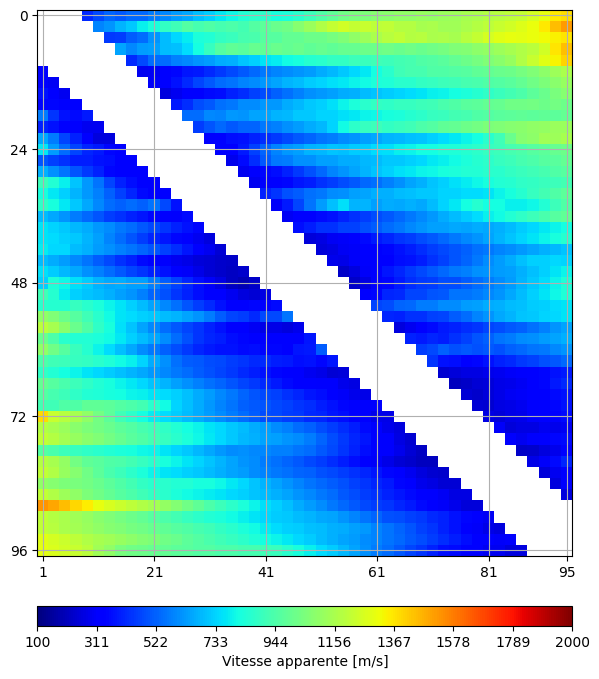

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

ax, cbar = mgr.showData(ax=ax, logScale=False, nLevs=10, cMap='jet',
                        label = 'Vitesse apparente [m/s]',
                        cMin=100, cMax=2000)

Text(0, 0.5, 'Temps de trajet [s]')

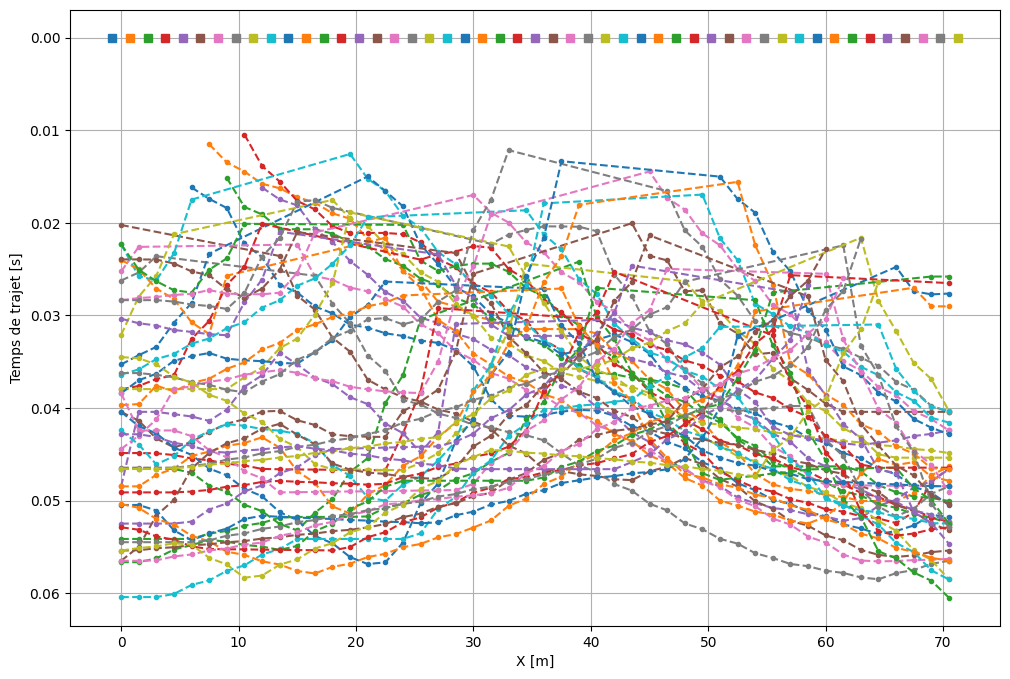

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
lines = tt.drawFirstPicks(ax, data, plotSource = True, 
                          **{'linestyle': '--', 'marker': 'o', 'markersize': '3'})
ax.set_xlabel("Х [m]")
ax.set_ylabel("Temps de trajet [s]")

## Inversion

In [10]:
mgr.invert()

./core/src/meshentities.cpp:36		GIMLI::Boundary* GIMLI::findBoundary_(const std::set<Boundary*>&)  pls. check, this should not happen.  There is more than one boundary defined.2
Boundary 0x55b4b0fc00c0 rtti: 22 id: 0	N: 0 1  marker: 1 
Boundary 0x55b4b141eff0 rtti: 22 id: 194	N: 4 0  marker: -1 
07/12/24 - 18:30:46 - pyGIMLi - INFO - Found 1 regions.
07/12/24 - 18:30:46 - pyGIMLi - INFO - Found 1 regions.
07/12/24 - 18:30:46 - pyGIMLi - INFO - Creating forward mesh from region infos.
07/12/24 - 18:30:46 - pyGIMLi - INFO - Creating refined mesh (secnodes: 2) to solve forward task.
07/12/24 - 18:30:46 - pyGIMLi - INFO - Create gradient starting model. 500: 5000
07/12/24 - 18:30:46 - pyGIMLi - INFO - Created startmodel from forward operator: 1432, min/max=0.000200/0.002000


1432 [165.41559015305336,...,2427.3547542371766]

Text(117.09722222222221, 0.5, 'Profondeur [m]')

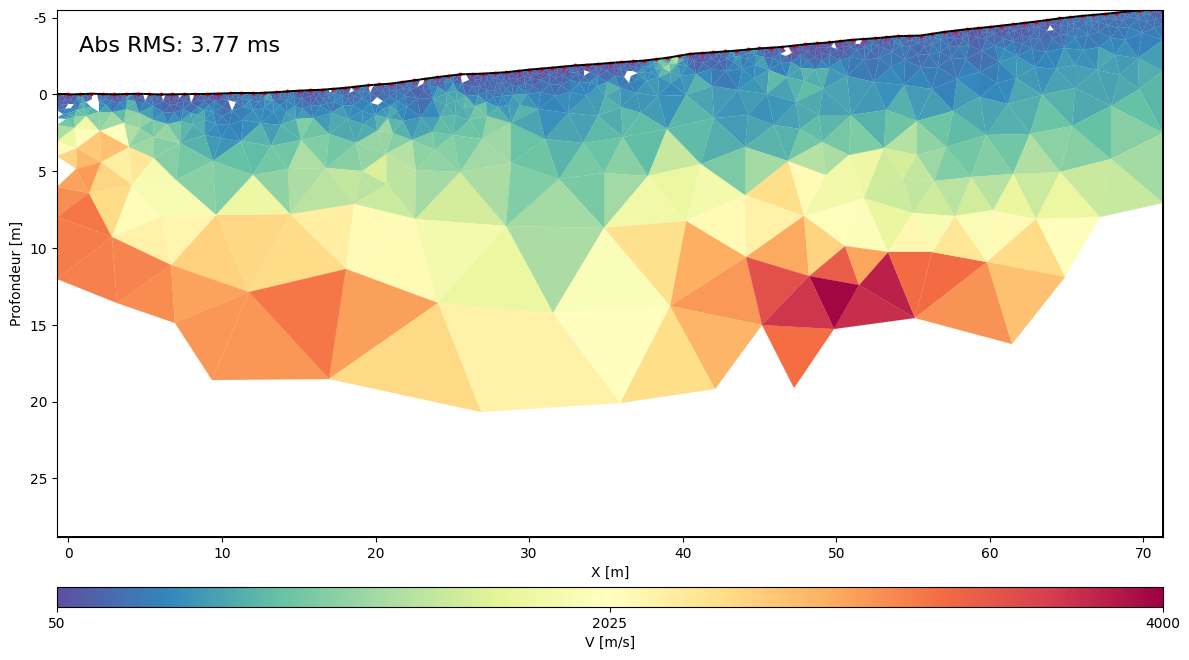

In [12]:
fig, ax = plt.subplots(figsize=(12, 8))
mgr.showResult(ax=ax, logScale=False, nLevs=3, cMap='Spectral_r', colorBar=True, log=False,
               cMin=50, cMax=4000, 
               fitView=True, label='V [m/s]',
               coverage=mgr.standardizedCoverage(),
              )
ax.scatter(data.sensors()[:, 0], data.sensors()[:, 1], s=3, c='r')
ax.text(0.02, 0.95, f'Abs RMS: {mgr.inv.absrms()*1000:.2f} ms', transform=ax.transAxes, fontsize=16, verticalalignment='top')
ax.set_xlabel("Х [m]")
ax.set_ylabel("Profondeur [m]")

(0.065, -0.005)

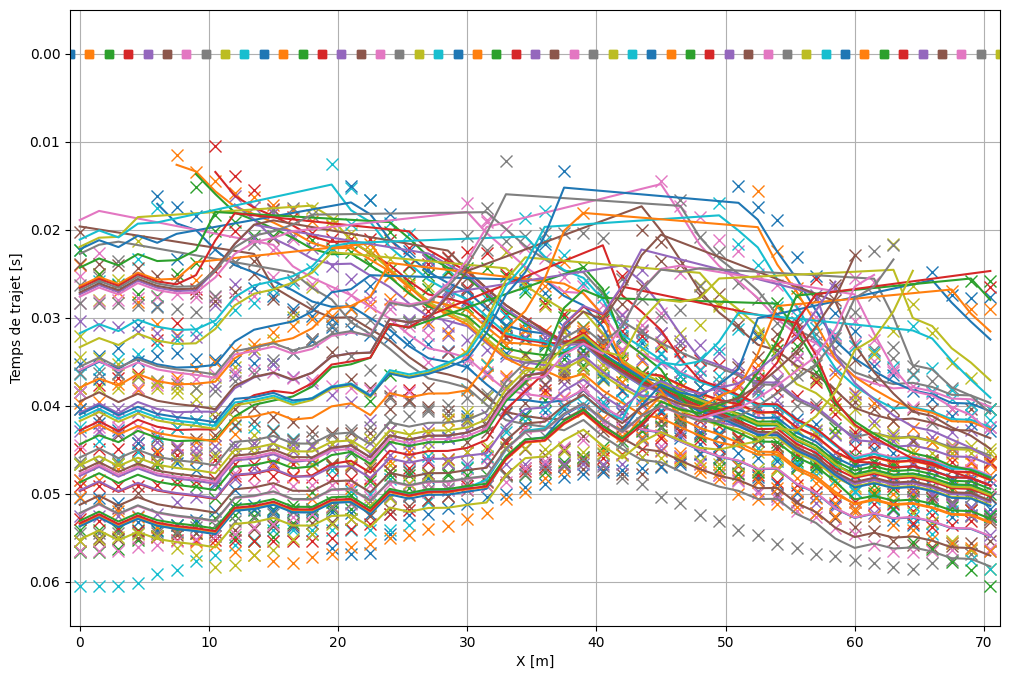

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
mgr.showFit(firstPicks=True, ax=ax)
ax.set_xlabel("Х [m]")
ax.set_ylabel("Temps de trajet [s]")
ax.set_xlim(np.min(pg.x(data)), np.max(pg.x(data)))
ax.set_ylim(0.065, -0.005)

In [14]:
inv = mgr.invert(secNodes=3, paraMaxCellSize=50.,
           zWeight=0.7, vTop=100, vBottom=3000,
           verbose=True, balanceDepth=False,
           lam=500, lambdaFactor = 0.5, dPhi = 2,)

07/12/24 - 18:33:04 - pyGIMLi - INFO - Create gradient starting model. 100: 3000
07/12/24 - 18:33:04 - pyGIMLi - INFO - Created startmodel from forward operator: 1432, min/max=0.000333/0.010000
07/12/24 - 18:33:04 - pyGIMLi - INFO - Starting inversion.


min/max(dweight) = 550.964/3187.53
fop: <pygimli.physics.traveltime.modelling.TravelTimeDijkstraModelling object at 0x7f8dab063740>
Data transformation: <pgcore._pygimli_.RTrans object at 0x7f8dab035b70>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x7f8dab988350>
min/max (data): 0.01/0.06
min/max (error): 3%/3%
min/max (start model): 3.3e-04/0.01
--------------------------------------------------------------------------------
use model trans from RegionManager
min/max(dweight) = 550.964/3187.53
Building constraints matrix
constraint matrix of size(nBounds x nModel) 2038 x 1432
inv.iter 0 ... chi² =  716.15Calculating Jacobian matrix (forced=1)...... 1.77819 s
min data = 0.0104574 max data = 0.0605 (1980)
min error = 0.03 max error = 0.0300001 (1980)
min response = 0.0389777 max response = 0.0940281 (1980)
calc without reference model
0: rms/rrms(data, response) = 0.0285304/80.2831%
0: chi^2(data, response, error, log) = 716.151
0: Phi = 1.41798e+06 + 

inv.iter 11 ... 10: Response: min = 0.0128921; max = 0.0586992
10: rms/rrms(data, Response) = 0.00363846/9.12598%
10: chi^2(data, Response, error, log) = 9.2537
10: Phi = 18322.3+92.0384*0.976562=18412.2
Calculating Jacobian matrix (forced=1)...... 2.8223 s
solve CGLSCDWWtrans with lambda = 0.488281
tau = 0. Trying parabolic line search with step length 0.3 ==> tau = 0.0639862
11: LS newModel: min = 5.0816e-06; max = 0.135321
11: LS newResponse: min = 0.00883242; max = 0.059135
11: rms/rrms(data, LS newResponse) = 0.0090411/22.185%
11: chi^2(data, LS newResponse, error, log) = 54.6858
11: Phi = 108278+954.947*0.488281=108744
Performing line search with tau = 0.0639862
chi² =    9.10 (dPhi = 1.81%) lam: 0.511: Model: min = 0.000202851; max = 0.0224807
11: Response: min = 0.012807; max = 0.0587754
11: rms/rrms(data, Response) = 0.0036176/9.05221%
11: chi^2(data, Response, error, log) = 9.10471
11: Phi = 18027.3+103.961*0.488281=18078.1

###################################################

Text(117.09722222222221, 0.5, 'Profondeur [m]')

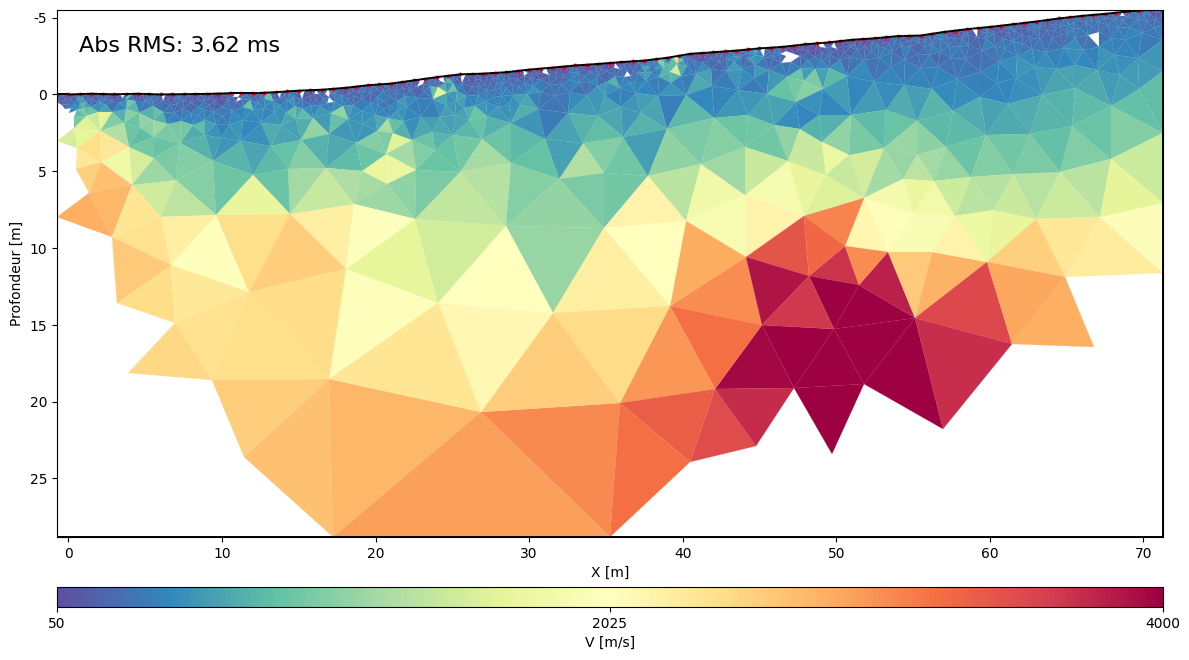

In [15]:
fig, ax = plt.subplots(figsize=(12, 8))
mgr.showResult(ax=ax, logScale=False, nLevs=3, cMap='Spectral_r', colorBar=True, log=False,
               cMin=50, cMax=4000, 
               fitView=True, label='V [m/s]',
               coverage=mgr.standardizedCoverage(),
              )
ax.scatter(data.sensors()[:, 0], data.sensors()[:, 1], s=3, c='r')
ax.text(0.02, 0.95, f'Abs RMS: {mgr.inv.absrms()*1000:.2f} ms', transform=ax.transAxes, fontsize=16, verticalalignment='top')
ax.set_xlabel("Х [m]")
ax.set_ylabel("Profondeur [m]")

In [16]:
inv = mgr.invert(secNodes=5, paraMaxCellSize=40.0,
           zWeight=0.2, vTop=100, vBottom=3000, verbose=1, usegradient=True, lam=40)

07/12/24 - 18:34:35 - pyGIMLi - INFO - Create gradient starting model. 100: 3000
07/12/24 - 18:34:35 - pyGIMLi - INFO - Created startmodel from forward operator: 1432, min/max=0.000333/0.010000
07/12/24 - 18:34:35 - pyGIMLi - INFO - Starting inversion.


min/max(dweight) = 550.964/3187.53
fop: <pygimli.physics.traveltime.modelling.TravelTimeDijkstraModelling object at 0x7f8dab063740>
Data transformation: <pgcore._pygimli_.RTrans object at 0x7f8dab035b70>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x7f8dab988f20>
min/max (data): 0.01/0.06
min/max (error): 3%/3%
min/max (start model): 3.3e-04/0.01
--------------------------------------------------------------------------------
use model trans from RegionManager
min/max(dweight) = 550.964/3187.53
Building constraints matrix
constraint matrix of size(nBounds x nModel) 2038 x 1432
inv.iter 0 ... chi² =  716.15Calculating Jacobian matrix (forced=1)...... 1.89616 s
min data = 0.0104574 max data = 0.0605 (1980)
min error = 0.03 max error = 0.0300001 (1980)
min response = 0.0389777 max response = 0.0940281 (1980)
calc without reference model
0: rms/rrms(data, response) = 0.0285304/80.2831%
0: chi^2(data, response, error, log) = 716.151
0: Phi = 1.41798e+06 + 

Calculating Jacobian matrix (forced=1)...... 1.60834 s
solve CGLSCDWWtrans with lambda = 40
tau = 0. Trying parabolic line search with step length 0.3 ==> tau = 0.0956825
11: LS newModel: min = 0.00013991; max = 0.0421848
11: LS newResponse: min = 0.0114692; max = 0.0551397
11: rms/rrms(data, LS newResponse) = 0.00490377/11.7652%
11: chi^2(data, LS newResponse, error, log) = 15.3801
11: Phi = 30452.5+47.0229*40=32333.4
Performing line search with tau = 0.0956825
chi² =    8.42 (dPhi = 2.26%) lam: 40.011: Model: min = 0.000209312; max = 0.0294585
11: Response: min = 0.0125609; max = 0.0592636
11: rms/rrms(data, Response) = 0.00347752/8.70571%

--------------------------------------------------------------------------------
inv.iter 12 ... 11: chi^2(data, Response, error, log) = 8.42103
11: Phi = 16673.6+29.6624*40=17860.1
Calculating Jacobian matrix (forced=1)...... 1.74895 s
solve CGLSCDWWtrans with lambda = 40
tau = 0. Trying parabolic line search with step length 0.3 ==> tau = 0.0468

Text(117.09722222222221, 0.5, 'Profondeur [m]')

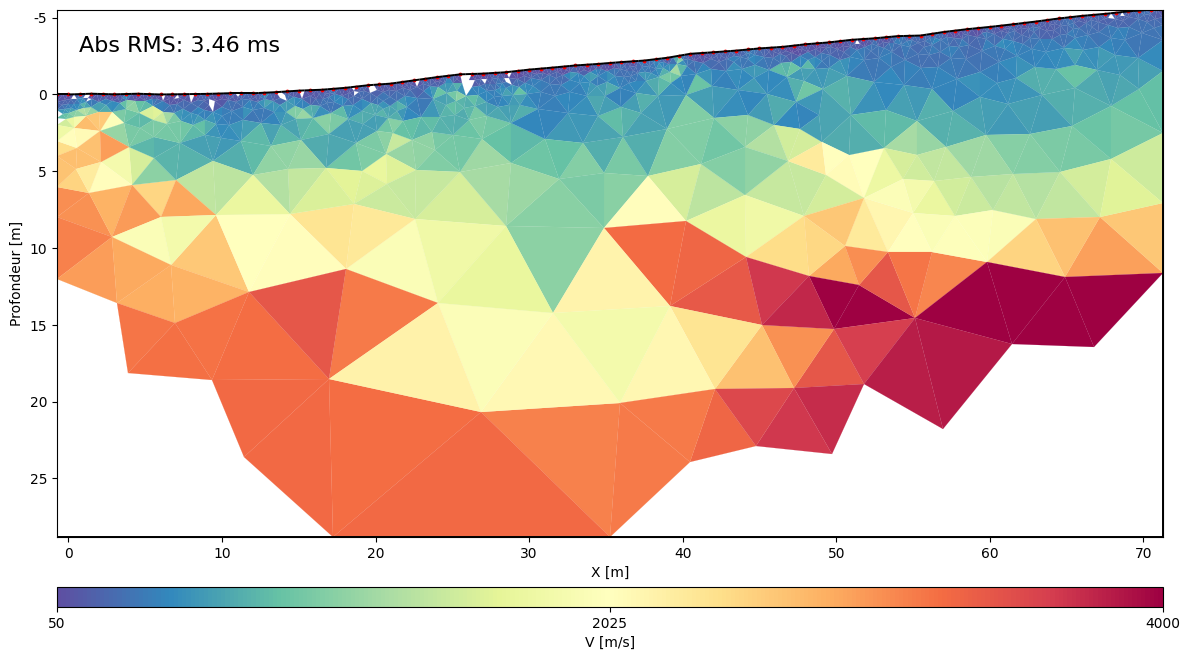

In [17]:
fig, ax = plt.subplots(figsize=(12, 8))
mgr.showResult(ax=ax, logScale=False, nLevs=3, cMap='Spectral_r', colorBar=True, log=False,
               cMin=50, cMax=4000, 
               fitView=True, label='V [m/s]',
               coverage=mgr.standardizedCoverage(),
              )
ax.scatter(data.sensors()[:, 0], data.sensors()[:, 1], s=3, c='r')
ax.text(0.02, 0.95, f'Abs RMS: {mgr.inv.absrms()*1000:.2f} ms', transform=ax.transAxes, fontsize=16, verticalalignment='top')
ax.set_xlabel("Х [m]")
ax.set_ylabel("Profondeur [m]")

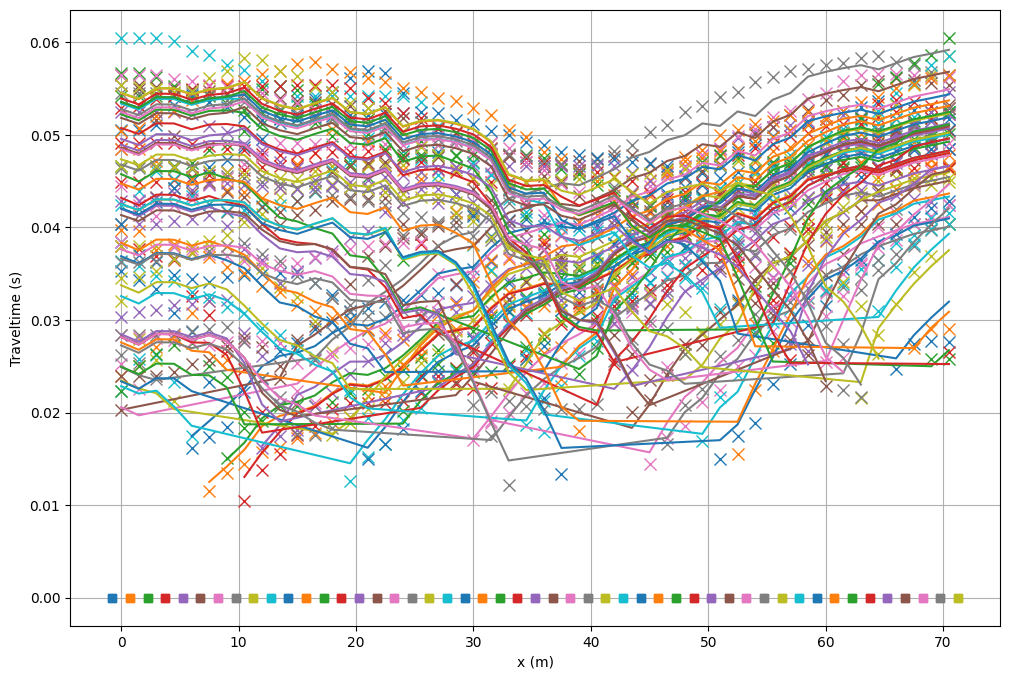

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

mgr.showFit(firstPicks=True, ax=ax)

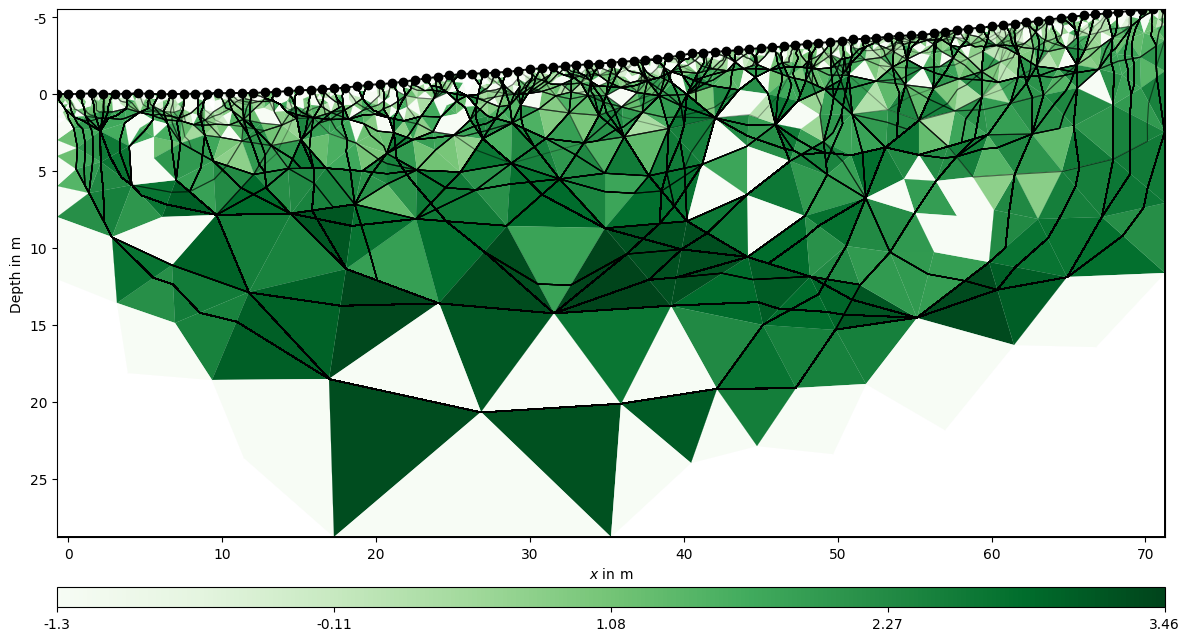

In [19]:
fig, ax = fig, ax = plt.subplots(1, 1, figsize=(12, 8))

sensors = data.sensorPositions()
mgr.showCoverage(ax=ax, cMap="Greens")
mgr.drawRayPaths(ax=ax, color="k", alpha=0.3)
p = ax.plot(sensors[:, 0], sensors[:, 1], "ko")

./core/src/meshentities.cpp:36		GIMLI::Boundary* GIMLI::findBoundary_(const std::set<Boundary*>&)  pls. check, this should not happen.  There is more than one boundary defined.2
Boundary 0x55c455517000 rtti: 22 id: 194	N: 4 0  marker: -1 
Boundary 0x55c45920f7d0 rtti: 22 id: 0	N: 0 1  marker: 1 
07/12/24 - 13:27:23 - pyGIMLi - INFO - Found 1 regions.
07/12/24 - 13:27:23 - pyGIMLi - INFO - Found 1 regions.
07/12/24 - 13:27:23 - pyGIMLi - INFO - Creating forward mesh from region infos.
07/12/24 - 13:27:23 - pyGIMLi - INFO - Creating refined mesh (secnodes: 5) to solve forward task.
07/12/24 - 13:27:23 - pyGIMLi - INFO - Create gradient starting model. 10: 1000
07/12/24 - 13:27:23 - pyGIMLi - INFO - Created startmodel from forward operator: 1433, min/max=0.001000/0.100000
07/12/24 - 13:27:23 - pyGIMLi - INFO - Starting inversion.


Constructing Delaunay triangulation by divide-and-conquer method.
Delaunay milliseconds:  0
Recovering segments in Delaunay triangulation.
Segment milliseconds:  0
Removing unwanted triangles.
Spreading regional attributes and area constraints.
Hole milliseconds:  0
Adding Steiner points to enforce quality.
Quality milliseconds:  1

Writing vertices.
Writing triangles.
Writing segments.
Writing edges.

Output milliseconds:  0
Total running milliseconds:  2

Statistics:

  Input vertices: 195
  Input segments: 196
  Input holes: 0

  Mesh vertices: 828
  Mesh triangles: 1433
  Mesh edges: 2260
  Mesh exterior boundary edges: 221
  Mesh interior boundary edges: 0
  Mesh subsegments (constrained edges): 221

min/max(dweight) = 550.964/3187.53
fop: <pygimli.physics.traveltime.modelling.TravelTimeDijkstraModelling object at 0x7f3aa4402430>
Data transformation: <pgcore._pygimli_.RTrans object at 0x7f3aa4599170>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x

chi² =   11.78 (dPhi = 3.06%) lam: 20.010: Model: min = 0.000229133; max = 0.0290727
10: Response: min = 0.0154058; max = 0.0587337
10: rms/rrms(data, Response) = 0.00399787/10.297%
10: chi^2(data, Response, error, log) = 11.7809
10: Phi = 23326.2+27.6361*20=23878.9

--------------------------------------------------------------------------------
inv.iter 11 ... Calculating Jacobian matrix (forced=1)...... 8.62135 s
solve CGLSCDWWtrans with lambda = 20
11: LS newModel: min = 0.000128211; max = 0.0398587
11: LS newResponse: min = 0.0126832; max = 0.0550048
11: rms/rrms(data, LS newResponse) = 0.00579596/13.8262%
11: chi^2(data, LS newResponse, error, log) = 21.2404
11: Phi = 42056+65.7753*20=43371.5
Performing line search with tau = 0.03
chi² =   11.52 (dPhi = 2.20%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 12 ... 11: Model: min = 0.000227249; max = 0.0291023
11: Response: min = 0.0152816; max = 0.0587369
11: rms/rrms(data, Resp

07/12/24 - 13:32:48 - pyGIMLi - INFO - Create gradient starting model. 10: 2000
07/12/24 - 13:32:48 - pyGIMLi - INFO - Created startmodel from forward operator: 1433, min/max=0.000500/0.100000
07/12/24 - 13:32:48 - pyGIMLi - INFO - Starting inversion.


min/max(dweight) = 550.964/3187.53
fop: <pygimli.physics.traveltime.modelling.TravelTimeDijkstraModelling object at 0x7f3aa4402430>
Data transformation: <pgcore._pygimli_.RTrans object at 0x7f3aa4599170>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x7f3aa5509d90>
min/max (data): 0.01/0.06
min/max (error): 3%/3%
min/max (start model): 5.0e-04/0.1
--------------------------------------------------------------------------------
use model trans from RegionManager
min/max(dweight) = 550.964/3187.53
 found valid constraints matrix. omit rebuild
constraint matrix of size(nBounds x nModel) 2039 x 1433
inv.iter 0 ... chi² = 11879.04
--------------------------------------------------------------------------------
inv.iter 1 ... Calculating Jacobian matrix (forced=1)...... 9.77925 s
min data = 0.0104574 max data = 0.0605 (1980)
min error = 0.03 max error = 0.0300001 (1980)
min response = 0.112373 max response = 0.211281 (1980)
calc without reference model
0: rms

11: LS newModel: min = 0.00013588; max = 0.0347072
11: LS newResponse: min = 0.00962193; max = 0.0552571
11: rms/rrms(data, LS newResponse) = 0.00613588/15.1332%
11: chi^2(data, LS newResponse, error, log) = 25.4459
11: Phi = 50383+70.1865*20=51786.7
Performing line search with tau = 0.116947
chi² =    9.36 (dPhi = 2.89%) lam: 20.011: Model: min = 0.000174701; max = 0.0281198
11: Response: min = 0.0136674; max = 0.0587745
11: rms/rrms(data, Response) = 0.00360853/9.17972%
11: chi^2(data, Response, error, log) = 9.36301
11: Phi = 18538.8+29.7488*20=19133.7

--------------------------------------------------------------------------------
inv.iter 12 ... Calculating Jacobian matrix (forced=1)...... 8.76068 s
solve CGLSCDWWtrans with lambda = 20
tau = 0. Trying parabolic line search with step length 0.3 ==> tau = 0.104804
12: LS newModel: min = 0.000103826; max = 0.0403989
12: LS newResponse: min = 0.0113714; max = 0.0594875
12: rms/rrms(data, LS newResponse) = 0.00510469/12.5615%
12: chi^

07/12/24 - 13:39:30 - pyGIMLi - INFO - Create gradient starting model. 10: 3000
07/12/24 - 13:39:30 - pyGIMLi - INFO - Created startmodel from forward operator: 1433, min/max=0.000333/0.100000
07/12/24 - 13:39:30 - pyGIMLi - INFO - Starting inversion.


min/max(dweight) = 550.964/3187.53
fop: <pygimli.physics.traveltime.modelling.TravelTimeDijkstraModelling object at 0x7f3aa4402430>
Data transformation: <pgcore._pygimli_.RTrans object at 0x7f3aa4599170>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x7f3aa5509ee0>
min/max (data): 0.01/0.06
min/max (error): 3%/3%
min/max (start model): 3.3e-04/0.1
--------------------------------------------------------------------------------
use model trans from RegionManager
min/max(dweight) = 550.964/3187.53
 found valid constraints matrix. omit rebuild
constraint matrix of size(nBounds x nModel) 2039 x 1433
inv.iter 0 ... chi² = 4732.25Calculating Jacobian matrix (forced=1)...... 10.134 s
min data = 0.0104574 max data = 0.0605 (1980)
min error = 0.03 max error = 0.0300001 (1980)
min response = 0.080832 max response = 0.153179 (1980)
calc without reference model
0: rms/rrms(data, response) = 0.0728901/206.374%
0: chi^2(data, response, error, log) = 4732.25
0: Phi = 

Calculating Jacobian matrix (forced=1)...... 8.53226 s
solve CGLSCDWWtrans with lambda = 20
tau = 0. Trying parabolic line search with step length 0.3 ==> tau = 0.162938
11: LS newModel: min = 0.000103255; max = 0.0443733
11: LS newResponse: min = 0.0116623; max = 0.0552903
11: rms/rrms(data, LS newResponse) = 0.00566202/13.4534%
11: chi^2(data, LS newResponse, error, log) = 20.1105
11: Phi = 39818.7+58.9977*20=40998.7
Performing line search with tau = 0.162938
chi² =   10.34 (dPhi = 3.52%) lam: 20.011: Model: min = 0.000213447; max = 0.0298076
11: Response: min = 0.0138828; max = 0.0591191

--------------------------------------------------------------------------------
inv.iter 12 ... 11: rms/rrms(data, Response) = 0.00390264/9.64551%
11: chi^2(data, Response, error, log) = 10.3373
11: Phi = 20467.8+29.5749*20=21059.3
Calculating Jacobian matrix (forced=1)...... 8.61567 s
solve CGLSCDWWtrans with lambda = 20
tau = 0. Trying parabolic line search with step length 0.3 ==> tau = 0.14248

07/12/24 - 13:47:49 - pyGIMLi - INFO - Create gradient starting model. 10: 4000
07/12/24 - 13:47:50 - pyGIMLi - INFO - Created startmodel from forward operator: 1433, min/max=0.000250/0.100000
07/12/24 - 13:47:50 - pyGIMLi - INFO - Starting inversion.


min/max(dweight) = 550.964/3187.53
fop: <pygimli.physics.traveltime.modelling.TravelTimeDijkstraModelling object at 0x7f3aa4402430>
Data transformation: <pgcore._pygimli_.RTrans object at 0x7f3aa4599170>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x7f3aa5509fc0>
min/max (data): 0.01/0.06
min/max (error): 3%/3%
min/max (start model): 2.5e-04/0.1
--------------------------------------------------------------------------------
use model trans from RegionManager
min/max(dweight) = 550.964/3187.53
 found valid constraints matrix. omit rebuild
constraint matrix of size(nBounds x nModel) 2039 x 1433
inv.iter 0 ... chi² = 2209.31Calculating Jacobian matrix (forced=1)...... 10.7767 s
min data = 0.0104574 max data = 0.0605 (1980)
min error = 0.03 max error = 0.0300001 (1980)
min response = 0.0633016 max response = 0.121756 (1980)
calc without reference model
0: rms/rrms(data, response) = 0.0480054/141.01%
0: chi^2(data, response, error, log) = 2209.31
0: Phi =

inv.iter 11 ... Calculating Jacobian matrix (forced=1)...... 8.61411 s
solve CGLSCDWWtrans with lambda = 20
tau = 0. Trying parabolic line search with step length 0.3 ==> tau = 0.111861
11: LS newModel: min = 0.000110744; max = 0.0885321
11: LS newResponse: min = 0.0103619; max = 0.055879
11: rms/rrms(data, LS newResponse) = 0.00621387/14.817%
11: chi^2(data, LS newResponse, error, log) = 24.3937
11: Phi = 48299.5+73.8151*20=49775.8
Performing line search with tau = 0.111861
chi² =    9.81 (dPhi = 3.45%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 12 ... 11: Model: min = 0.000169886; max = 0.0253976
11: Response: min = 0.0133956; max = 0.059836
11: rms/rrms(data, Response) = 0.00373822/9.39802%
11: chi^2(data, Response, error, log) = 9.81362
11: Phi = 19431+36.3497*20=20158
Calculating Jacobian matrix (forced=1)...... 8.70342 s
solve CGLSCDWWtrans with lambda = 20
tau = 0. Trying parabolic line search with step length 0.3 ==> tau 

07/12/24 - 13:55:02 - pyGIMLi - INFO - Create gradient starting model. 50: 1000
07/12/24 - 13:55:02 - pyGIMLi - INFO - Created startmodel from forward operator: 1433, min/max=0.001000/0.020000
07/12/24 - 13:55:02 - pyGIMLi - INFO - Starting inversion.


min/max(dweight) = 550.964/3187.53
fop: <pygimli.physics.traveltime.modelling.TravelTimeDijkstraModelling object at 0x7f3aa4402430>
Data transformation: <pgcore._pygimli_.RTrans object at 0x7f3aa4599170>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x7f3aa5509d90>
min/max (data): 0.01/0.06
min/max (error): 3%/3%
min/max (start model): 1.0e-03/0.02
--------------------------------------------------------------------------------
use model trans from RegionManager
min/max(dweight) = 550.964/3187.53
 found valid constraints matrix. omit rebuild
constraint matrix of size(nBounds x nModel) 2039 x 1433
inv.iter 0 ... chi² = 14303.97Calculating Jacobian matrix (forced=1)...... 8.45993 s
min data = 0.0104574 max data = 0.0605 (1980)
min error = 0.03 max error = 0.0300001 (1980)
min response = 0.0941316 max response = 0.254447 (1980)
calc without reference model
0: rms/rrms(data, response) = 0.14066/358.798%
0: chi^2(data, response, error, log) = 14304
0: Phi = 

solve CGLSCDWWtrans with lambda = 20
tau = 0. Trying parabolic line search with step length 0.3 ==> tau = 0.0839961
11: LS newModel: min = 7.31843e-05; max = 0.0389581
11: LS newResponse: min = 0.0114885; max = 0.0582999
11: rms/rrms(data, LS newResponse) = 0.00544985/13.2023%
11: chi^2(data, LS newResponse, error, log) = 19.3667
11: Phi = 38346.1+73.7107*20=39820.3
Performing line search with tau = 0.0839961
chi² =    8.59 (dPhi = 1.59%) lam: 20.011: Model: min = 0.000214781; max = 0.0269552
11: Response: min = 0.0127164; max = 0.0600168

################################################################################
#                Abort criterion reached: dPhi = 1.59 (< 2.0%)                 #
################################################################################
11: rms/rrms(data, Response) = 0.00352263/8.79213%
11: chi^2(data, Response, error, log) = 8.58905
11: Phi = 17006.3+33.7679*20=17681.7


07/12/24 - 14:00:37 - pyGIMLi - INFO - Create gradient starting model. 50: 2000
07/12/24 - 14:00:37 - pyGIMLi - INFO - Created startmodel from forward operator: 1433, min/max=0.000500/0.020000
07/12/24 - 14:00:37 - pyGIMLi - INFO - Starting inversion.


min/max(dweight) = 550.964/3187.53
fop: <pygimli.physics.traveltime.modelling.TravelTimeDijkstraModelling object at 0x7f3aa4402430>
Data transformation: <pgcore._pygimli_.RTrans object at 0x7f3aa4599170>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x7f3aa5509fc0>
min/max (data): 0.01/0.06
min/max (error): 3%/3%
min/max (start model): 5.0e-04/0.02
--------------------------------------------------------------------------------
use model trans from RegionManager
min/max(dweight) = 550.964/3187.53
 found valid constraints matrix. omit rebuild
constraint matrix of size(nBounds x nModel) 2039 x 1433
inv.iter 0 ... chi² = 4000.22Calculating Jacobian matrix (forced=1)...... 8.62142 s
min data = 0.0104574 max data = 0.0605 (1980)
min error = 0.03 max error = 0.0300001 (1980)
min response = 0.0668261 max response = 0.149148 (1980)
calc without reference model
0: rms/rrms(data, response) = 0.0706387/189.742%
0: chi^2(data, response, error, log) = 4000.22
0: Phi

10: Model: min = 0.000211386; max = 0.0314108
10: Response: min = 0.0127339; max = 0.0594702
10: rms/rrms(data, Response) = 0.00356853/8.81807%
10: chi^2(data, Response, error, log) = 8.6398
10: Phi = 17106.8+36.7229*20=17841.3
chi² =    8.64 (dPhi = 2.00%) lam: 20.0
################################################################################
#                 Abort criterion reached: dPhi = 2.0 (< 2.0%)                 #
################################################################################


07/12/24 - 14:06:18 - pyGIMLi - INFO - Create gradient starting model. 50: 3000
07/12/24 - 14:06:18 - pyGIMLi - INFO - Created startmodel from forward operator: 1433, min/max=0.000333/0.020000
07/12/24 - 14:06:18 - pyGIMLi - INFO - Starting inversion.


min/max(dweight) = 550.964/3187.53
fop: <pygimli.physics.traveltime.modelling.TravelTimeDijkstraModelling object at 0x7f3aa4402430>
Data transformation: <pgcore._pygimli_.RTrans object at 0x7f3aa4599170>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x7f3aa5509c40>
min/max (data): 0.01/0.06
min/max (error): 3%/3%
min/max (start model): 3.3e-04/0.02
--------------------------------------------------------------------------------
use model trans from RegionManager
min/max(dweight) = 550.964/3187.53
 found valid constraints matrix. omit rebuild
constraint matrix of size(nBounds x nModel) 2039 x 1433
inv.iter 0 ... chi² = 1563.05
--------------------------------------------------------------------------------
inv.iter 1 ... Calculating Jacobian matrix (forced=1)...... 9.48621 s
min data = 0.0104574 max data = 0.0605 (1980)
min error = 0.03 max error = 0.0300001 (1980)
min response = 0.0526482 max response = 0.10872 (1980)
calc without reference model
0: rms

Calculating Jacobian matrix (forced=1)...... 8.77383 s
solve CGLSCDWWtrans with lambda = 20
tau = 0. Trying parabolic line search with step length 0.3 ==> tau = 0.109001
11: LS newModel: min = 0.000170264; max = 0.0338465
11: LS newResponse: min = 0.0113726; max = 0.0569366
11: rms/rrms(data, LS newResponse) = 0.00538208/12.9439%
11: chi^2(data, LS newResponse, error, log) = 18.6161
11: Phi = 36859.9+64.4697*20=38149.3
Performing line search with tau = 0.109001
chi² =    8.52 (dPhi = 2.21%) lam: 20.011: Model: min = 0.000215115; max = 0.0291176
11: Response: min = 0.013285; max = 0.0590864
11: rms/rrms(data, Response) = 0.00346565/8.75661%
11: chi^2(data, Response, error, log) = 8.51978

--------------------------------------------------------------------------------
inv.iter 12 ... 11: Phi = 16869.2+39.333*20=17655.8
Calculating Jacobian matrix (forced=1)...... 9.30503 s
solve CGLSCDWWtrans with lambda = 20
tau = 0. Trying parabolic line search with step length 0.3 ==> tau = 0.0769412

07/12/24 - 14:12:50 - pyGIMLi - INFO - Create gradient starting model. 50: 4000
07/12/24 - 14:12:50 - pyGIMLi - INFO - Created startmodel from forward operator: 1433, min/max=0.000250/0.020000
07/12/24 - 14:12:50 - pyGIMLi - INFO - Starting inversion.


min/max(dweight) = 550.964/3187.53
fop: <pygimli.physics.traveltime.modelling.TravelTimeDijkstraModelling object at 0x7f3aa4402430>
Data transformation: <pgcore._pygimli_.RTrans object at 0x7f3aa4599170>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x7f3aa5509d90>
min/max (data): 0.01/0.06
min/max (error): 3%/3%
min/max (start model): 2.5e-04/0.02
--------------------------------------------------------------------------------
use model trans from RegionManager
min/max(dweight) = 550.964/3187.53
 found valid constraints matrix. omit rebuild
constraint matrix of size(nBounds x nModel) 2039 x 1433
inv.iter 0 ... chi² =  689.15Calculating Jacobian matrix (forced=1)...... 9.41187 s
min data = 0.0104574 max data = 0.0605 (1980)
min error = 0.03 max error = 0.0300001 (1980)
min response = 0.0438364 max response = 0.0867795 (1980)
calc without reference model
0: rms/rrms(data, response) = 0.0260589/78.7551%
0: chi^2(data, response, error, log) = 689.15
0: Phi

07/12/24 - 14:17:37 - pyGIMLi - INFO - Create gradient starting model. 100: 1000
07/12/24 - 14:17:37 - pyGIMLi - INFO - Created startmodel from forward operator: 1433, min/max=0.001000/0.010000
07/12/24 - 14:17:37 - pyGIMLi - INFO - Starting inversion.


min/max(dweight) = 550.964/3187.53
fop: <pygimli.physics.traveltime.modelling.TravelTimeDijkstraModelling object at 0x7f3aa4402430>
Data transformation: <pgcore._pygimli_.RTrans object at 0x7f3aa4599170>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x7f3aa550a340>
min/max (data): 0.01/0.06
min/max (error): 3%/3%
min/max (start model): 1.0e-03/0.01
--------------------------------------------------------------------------------
use model trans from RegionManager
min/max(dweight) = 550.964/3187.53
 found valid constraints matrix. omit rebuild
constraint matrix of size(nBounds x nModel) 2039 x 1433
inv.iter 0 ... chi² = 6936.87
--------------------------------------------------------------------------------
inv.iter 1 ... Calculating Jacobian matrix (forced=1)...... 8.41678 s
min data = 0.0104574 max data = 0.0605 (1980)
min error = 0.03 max error = 0.0300001 (1980)
min response = 0.0585681 max response = 0.214068 (1980)
calc without reference model
0: rm

07/12/24 - 14:24:54 - pyGIMLi - INFO - Create gradient starting model. 100: 2000
07/12/24 - 14:24:54 - pyGIMLi - INFO - Created startmodel from forward operator: 1433, min/max=0.000500/0.010000
07/12/24 - 14:24:54 - pyGIMLi - INFO - Starting inversion.


min/max(dweight) = 550.964/3187.53
fop: <pygimli.physics.traveltime.modelling.TravelTimeDijkstraModelling object at 0x7f3aa4402430>
Data transformation: <pgcore._pygimli_.RTrans object at 0x7f3aa4599170>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x7f3aa550a3b0>
min/max (data): 0.01/0.06
min/max (error): 3%/3%
min/max (start model): 5.0e-04/0.01
--------------------------------------------------------------------------------
use model trans from RegionManager
min/max(dweight) = 550.964/3187.53
 found valid constraints matrix. omit rebuild
constraint matrix of size(nBounds x nModel) 2039 x 1433
inv.iter 0 ... chi² = 1920.46
--------------------------------------------------------------------------------
inv.iter 1 ... Calculating Jacobian matrix (forced=1)...... 8.76507 s
min data = 0.0104574 max data = 0.0605 (1980)
min error = 0.03 max error = 0.0300001 (1980)
min response = 0.0470658 max response = 0.127224 (1980)
calc without reference model
0: rm

10: Response: min = 0.0123788; max = 0.0597502
10: rms/rrms(data, Response) = 0.00350664/8.8088%
10: chi^2(data, Response, error, log) = 8.62165
10: Phi = 17070.9+35.1517*20=17773.9
Calculating Jacobian matrix (forced=1)...... 11.0253 s
solve CGLSCDWWtrans with lambda = 20
tau = 0. Trying parabolic line search with step length 0.3 ==> tau = 0.106966
11: LS newModel: min = 0.000131088; max = 0.0393962
11: LS newResponse: min = 0.0114987; max = 0.0564891
11: rms/rrms(data, LS newResponse) = 0.00527823/12.651%
11: chi^2(data, LS newResponse, error, log) = 17.7831
11: Phi = 35210.5+68.8855*20=36588.2
Performing line search with tau = 0.106966
chi² =    8.46 (dPhi = 1.73%) lam: 20.011: Model: min = 0.000208158; max = 0.0300957
11: Response: min = 0.01227; max = 0.0596157

################################################################################
#                Abort criterion reached: dPhi = 1.73 (< 2.0%)                 #
############################################################

07/12/24 - 14:32:41 - pyGIMLi - INFO - Create gradient starting model. 100: 3000
07/12/24 - 14:32:41 - pyGIMLi - INFO - Created startmodel from forward operator: 1433, min/max=0.000333/0.010000
07/12/24 - 14:32:41 - pyGIMLi - INFO - Starting inversion.


min/max(dweight) = 550.964/3187.53
fop: <pygimli.physics.traveltime.modelling.TravelTimeDijkstraModelling object at 0x7f3aa4402430>
Data transformation: <pgcore._pygimli_.RTrans object at 0x7f3aa4599170>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x7f3aa550af80>
min/max (data): 0.01/0.06
min/max (error): 3%/3%
min/max (start model): 3.3e-04/0.01
--------------------------------------------------------------------------------
use model trans from RegionManager
min/max(dweight) = 550.964/3187.53
 found valid constraints matrix. omit rebuild
constraint matrix of size(nBounds x nModel) 2039 x 1433
inv.iter 0 ... chi² =  694.92Calculating Jacobian matrix (forced=1)...... 9.15899 s

--------------------------------------------------------------------------------
inv.iter 1 ... min data = 0.0104574 max data = 0.0605 (1980)
min error = 0.03 max error = 0.0300001 (1980)
min response = 0.0389002 max response = 0.0932 (1980)
calc without reference model
0: rms/

chi² =    9.11 (dPhi = 2.89%) lam: 20.010: Model: min = 0.000220627; max = 0.0243711
10: Response: min = 0.012213; max = 0.0584977

--------------------------------------------------------------------------------
inv.iter 11 ... 10: rms/rrms(data, Response) = 0.00364532/9.05399%
10: chi^2(data, Response, error, log) = 9.10828
10: Phi = 18034.4+40.0153*20=18834.7
Calculating Jacobian matrix (forced=1)...... 9.70079 s
solve CGLSCDWWtrans with lambda = 20
tau = 0. Trying parabolic line search with step length 0.3 ==> tau = 0.0993108
11: LS newModel: min = 0.000145028; max = 0.036399
11: LS newResponse: min = 0.00954867; max = 0.0565876
11: rms/rrms(data, LS newResponse) = 0.00563105/13.3916%
11: chi^2(data, LS newResponse, error, log) = 19.9261
11: Phi = 39453.7+68.9696*20=40833.1
Performing line search with tau = 0.0993108
chi² =    8.92 (dPhi = 1.95%) lam: 20.011: Model: min = 0.000216348; max = 0.0253616

################################################################################


07/12/24 - 14:40:39 - pyGIMLi - INFO - Create gradient starting model. 100: 4000
07/12/24 - 14:40:39 - pyGIMLi - INFO - Created startmodel from forward operator: 1433, min/max=0.000250/0.010000
07/12/24 - 14:40:39 - pyGIMLi - INFO - Starting inversion.


min/max(dweight) = 550.964/3187.53
fop: <pygimli.physics.traveltime.modelling.TravelTimeDijkstraModelling object at 0x7f3aa4402430>
Data transformation: <pgcore._pygimli_.RTrans object at 0x7f3aa4599170>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x7f3aa550af80>
min/max (data): 0.01/0.06
min/max (error): 3%/3%
min/max (start model): 2.5e-04/0.01
--------------------------------------------------------------------------------
use model trans from RegionManager
min/max(dweight) = 550.964/3187.53
 found valid constraints matrix. omit rebuild
constraint matrix of size(nBounds x nModel) 2039 x 1433
inv.iter 0 ... chi² =  273.16Calculating Jacobian matrix (forced=1)...... 10.5236 s
min data = 0.0104574 max data = 0.0605 (1980)
min error = 0.03 max error = 0.0300001 (1980)
min response = 0.0334131 max response = 0.0745739 (1980)
calc without reference model
0: rms/rrms(data, response) = 0.0158589/49.5824%
0: chi^2(data, response, error, log) = 273.156
0: Ph

chi² =    9.79 (dPhi = 4.39%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 11 ... 10: Model: min = 0.00020401; max = 0.025893
10: Response: min = 0.0129723; max = 0.0590594
10: rms/rrms(data, Response) = 0.0037717/9.38645%
10: chi^2(data, Response, error, log) = 9.78948
10: Phi = 19383.2+37.2793*20=20128.8
Calculating Jacobian matrix (forced=1)...... 10.5224 s
solve CGLSCDWWtrans with lambda = 20
tau = 0. Trying parabolic line search with step length 0.3 ==> tau = 0.119697
11: LS newModel: min = 0.000123112; max = 0.0700788
11: LS newResponse: min = 0.0107359; max = 0.0573796
11: rms/rrms(data, LS newResponse) = 0.00559663/13.1327%
11: chi^2(data, LS newResponse, error, log) = 19.163
11: Phi = 37942.7+70.7138*20=39356.9
Performing line search with tau = 0.119697
chi² =    9.46 (dPhi = 3.23%) lam: 20.011: Model: min = 0.00019824; max = 0.0266637
11: Response: min = 0.012729; max = 0.0590799
11: rms/rrms(data, Response) = 0.00372757/

07/12/24 - 14:50:22 - pyGIMLi - INFO - Create gradient starting model. 1000: 1000
07/12/24 - 14:50:22 - pyGIMLi - INFO - Created startmodel from forward operator: 1433, min/max=0.001000/0.001000
07/12/24 - 14:50:22 - pyGIMLi - INFO - Starting inversion.


min/max(dweight) = 550.964/3187.53
fop: <pygimli.physics.traveltime.modelling.TravelTimeDijkstraModelling object at 0x7f3aa4402430>
Data transformation: <pgcore._pygimli_.RTrans object at 0x7f3aa4599170>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x7f3aa550b4c0>
min/max (data): 0.01/0.06
min/max (error): 3%/3%
min/max (start model): 1.0e-03/1.0e-03
--------------------------------------------------------------------------------
use model trans from RegionManager
min/max(dweight) = 550.964/3187.53
 found valid constraints matrix. omit rebuild
constraint matrix of size(nBounds x nModel) 2039 x 1433
inv.iter 0 ... chi² =  205.45
--------------------------------------------------------------------------------
inv.iter 1 ... Calculating Jacobian matrix (forced=1)...... 9.67985 s
min data = 0.0104574 max data = 0.0605 (1980)
min error = 0.03 max error = 0.0300001 (1980)
min response = 0.00675122 max response = 0.0715368 (1980)
calc without reference model


chi² =   15.40 (dPhi = 8.26%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 11 ... 10: Model: min = 0.000228672; max = 0.0448126
10: Response: min = 0.0125841; max = 0.0589369
10: rms/rrms(data, Response) = 0.00486453/11.773%
10: chi^2(data, Response, error, log) = 15.4003
10: Phi = 30492.6+39.3158*20=31278.9
Calculating Jacobian matrix (forced=1)...... 13.6337 s
solve CGLSCDWWtrans with lambda = 20
tau = 0. Trying parabolic line search with step length 0.3 ==> tau = 0.0314251
11: LS newModel: min = 0.000100781; max = 0.0495411
11: LS newResponse: min = 0.0113744; max = 0.0515056
11: rms/rrms(data, LS newResponse) = 0.00866585/20.0999%
11: chi^2(data, LS newResponse, error, log) = 44.8895
11: Phi = 88881.2+70.9408*20=90300
Performing line search with tau = 0.0314251
chi² =   15.04 (dPhi = 2.30%) lam: 20.011: Model: min = 0.000231233; max = 0.044282
11: Response: min = 0.0125459; max = 0.0588416

-------------------------------------

07/12/24 - 15:03:54 - pyGIMLi - INFO - Create gradient starting model. 1000: 2000
07/12/24 - 15:03:54 - pyGIMLi - INFO - Created startmodel from forward operator: 1433, min/max=0.000500/0.001000
07/12/24 - 15:03:54 - pyGIMLi - INFO - Starting inversion.


min/max(dweight) = 550.964/3187.53
fop: <pygimli.physics.traveltime.modelling.TravelTimeDijkstraModelling object at 0x7f3aa4402430>
Data transformation: <pgcore._pygimli_.RTrans object at 0x7f3aa4599170>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x7f3aa550b1b0>
min/max (data): 0.01/0.06
min/max (error): 3%/3%
min/max (start model): 5.0e-04/1.0e-03
--------------------------------------------------------------------------------
use model trans from RegionManager
min/max(dweight) = 550.964/3187.53
 found valid constraints matrix. omit rebuild
constraint matrix of size(nBounds x nModel) 2039 x 1433
inv.iter 0 ... chi² =  210.33Calculating Jacobian matrix (forced=1)...... 8.75957 s
min data = 0.0104574 max data = 0.0605 (1980)
min error = 0.03 max error = 0.0300001 (1980)
min response = 0.00674029 max response = 0.0615289 (1980)
calc without reference model
0: rms/rrms(data, response) = 0.0164435/43.5081%
0: chi^2(data, response, error, log) = 210.328
0

tau = 0. Trying parabolic line search with step length 0.3 ==> tau = 0.153873
10: LS newModel: min = 7.3812e-05; max = 0.0468434
10: LS newResponse: min = 0.0109749; max = 0.054513
10: rms/rrms(data, LS newResponse) = 0.00637046/15.0954%
10: chi^2(data, LS newResponse, error, log) = 25.3189
10: Phi = 50131.5+69.2087*20=51515.6
Performing line search with tau = 0.153873
10: Model: min = 0.000182621; max = 0.0375174
10: Response: min = 0.0114458; max = 0.0590696
10: rms/rrms(data, Response) = 0.00427412/10.1575%
10: chi^2(data, Response, error, log) = 11.4638
10: Phi = 22698.3+45.1966*20=23602.3
chi² =   11.46 (dPhi = 5.41%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 11 ... Calculating Jacobian matrix (forced=1)...... 16.4649 s
solve CGLSCDWWtrans with lambda = 20
tau = 0. Trying parabolic line search with step length 0.3 ==> tau = 0.119865
11: LS newModel: min = 0.000197951; max = 0.0479138
11: LS newResponse: min = 0.0119446; max

07/12/24 - 15:17:21 - pyGIMLi - INFO - Create gradient starting model. 1000: 3000
07/12/24 - 15:17:21 - pyGIMLi - INFO - Created startmodel from forward operator: 1433, min/max=0.000333/0.001000
07/12/24 - 15:17:21 - pyGIMLi - INFO - Starting inversion.


min/max(dweight) = 550.964/3187.53
fop: <pygimli.physics.traveltime.modelling.TravelTimeDijkstraModelling object at 0x7f3aa4402430>
Data transformation: <pgcore._pygimli_.RTrans object at 0x7f3aa4599170>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x7f3aa550b610>
min/max (data): 0.01/0.06
min/max (error): 3%/3%
min/max (start model): 3.3e-04/1.0e-03
--------------------------------------------------------------------------------
use model trans from RegionManager
min/max(dweight) = 550.964/3187.53
 found valid constraints matrix. omit rebuild
constraint matrix of size(nBounds x nModel) 2039 x 1433
inv.iter 0 ... chi² =  237.91
--------------------------------------------------------------------------------
inv.iter 1 ... Calculating Jacobian matrix (forced=1)...... 8.59766 s
min data = 0.0104574 max data = 0.0605 (1980)
min error = 0.03 max error = 0.0300001 (1980)
min response = 0.00672127 max response = 0.0492199 (1980)
calc without reference model


tau = 0. Trying parabolic line search with step length 0.3 ==> tau = 0.112421
10: LS newModel: min = 0.000177374; max = 0.0562357
10: LS newResponse: min = 0.0119618; max = 0.0546665
10: rms/rrms(data, LS newResponse) = 0.00560323/13.3589%
10: chi^2(data, LS newResponse, error, log) = 19.8287
10: Phi = 39260.9+70.1003*20=40662.9
Performing line search with tau = 0.112421
10: Model: min = 0.000240561; max = 0.0377095
10: Response: min = 0.0112565; max = 0.0568543
10: rms/rrms(data, Response) = 0.00407045/9.69028%
10: chi^2(data, Response, error, log) = 10.4335
10: Phi = 20658.3+40.3713*20=21465.7
chi² =   10.43 (dPhi = 4.03%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 11 ... Calculating Jacobian matrix (forced=1)...... 12.4507 s
solve CGLSCDWWtrans with lambda = 20
tau = 0. Trying parabolic line search with step length 0.3 ==> tau = 0.144091
11: LS newModel: min = 0.000214204; max = 0.0469838
11: LS newResponse: min = 0.0115401; m

07/12/24 - 15:28:02 - pyGIMLi - INFO - Create gradient starting model. 1000: 4000
07/12/24 - 15:28:02 - pyGIMLi - INFO - Created startmodel from forward operator: 1433, min/max=0.000250/0.001000
07/12/24 - 15:28:02 - pyGIMLi - INFO - Starting inversion.


min/max(dweight) = 550.964/3187.53
fop: <pygimli.physics.traveltime.modelling.TravelTimeDijkstraModelling object at 0x7f3aa4402430>
Data transformation: <pgcore._pygimli_.RTrans object at 0x7f3aa4599170>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x7f3aa550b450>
min/max (data): 0.01/0.06
min/max (error): 3%/3%
min/max (start model): 2.5e-04/1.0e-03
--------------------------------------------------------------------------------
use model trans from RegionManager
min/max(dweight) = 550.964/3187.53
 found valid constraints matrix. omit rebuild
constraint matrix of size(nBounds x nModel) 2039 x 1433
inv.iter 0 ... chi² =  277.73Calculating Jacobian matrix (forced=1)...... 11.5004 s
min data = 0.0104574 max data = 0.0605 (1980)
min error = 0.03 max error = 0.0300001 (1980)
min response = 0.00664452 max response = 0.0409162 (1980)
calc without reference model
0: rms/rrms(data, response) = 0.019977/49.9958%
0: chi^2(data, response, error, log) = 277.73
0: 

chi² =   11.66 (dPhi = 5.12%) lam: 20.010: Model: min = 0.000176811; max = 0.0313063
10: Response: min = 0.0116612; max = 0.0569278
10: rms/rrms(data, Response) = 0.00430908/10.243%
10: chi^2(data, Response, error, log) = 11.6576
10: Phi = 23082.1+39.5804*20=23873.7

--------------------------------------------------------------------------------
inv.iter 11 ... Calculating Jacobian matrix (forced=1)...... 10.2123 s
solve CGLSCDWWtrans with lambda = 20
tau = 0. Trying parabolic line search with step length 0.3 ==> tau = 0.199509
11: LS newModel: min = 0.000212611; max = 0.0453539
11: LS newResponse: min = 0.0115762; max = 0.0553458
11: rms/rrms(data, LS newResponse) = 0.00548687/13.3947%
11: chi^2(data, LS newResponse, error, log) = 19.9352
11: Phi = 39471.6+67.2375*20=40816.4
Performing line search with tau = 0.199509
chi² =   10.96 (dPhi = 5.87%) lam: 20.011: Model: min = 0.000184384; max = 0.03187
11: Response: min = 0.011682; max = 0.0572892

---------------------------------------

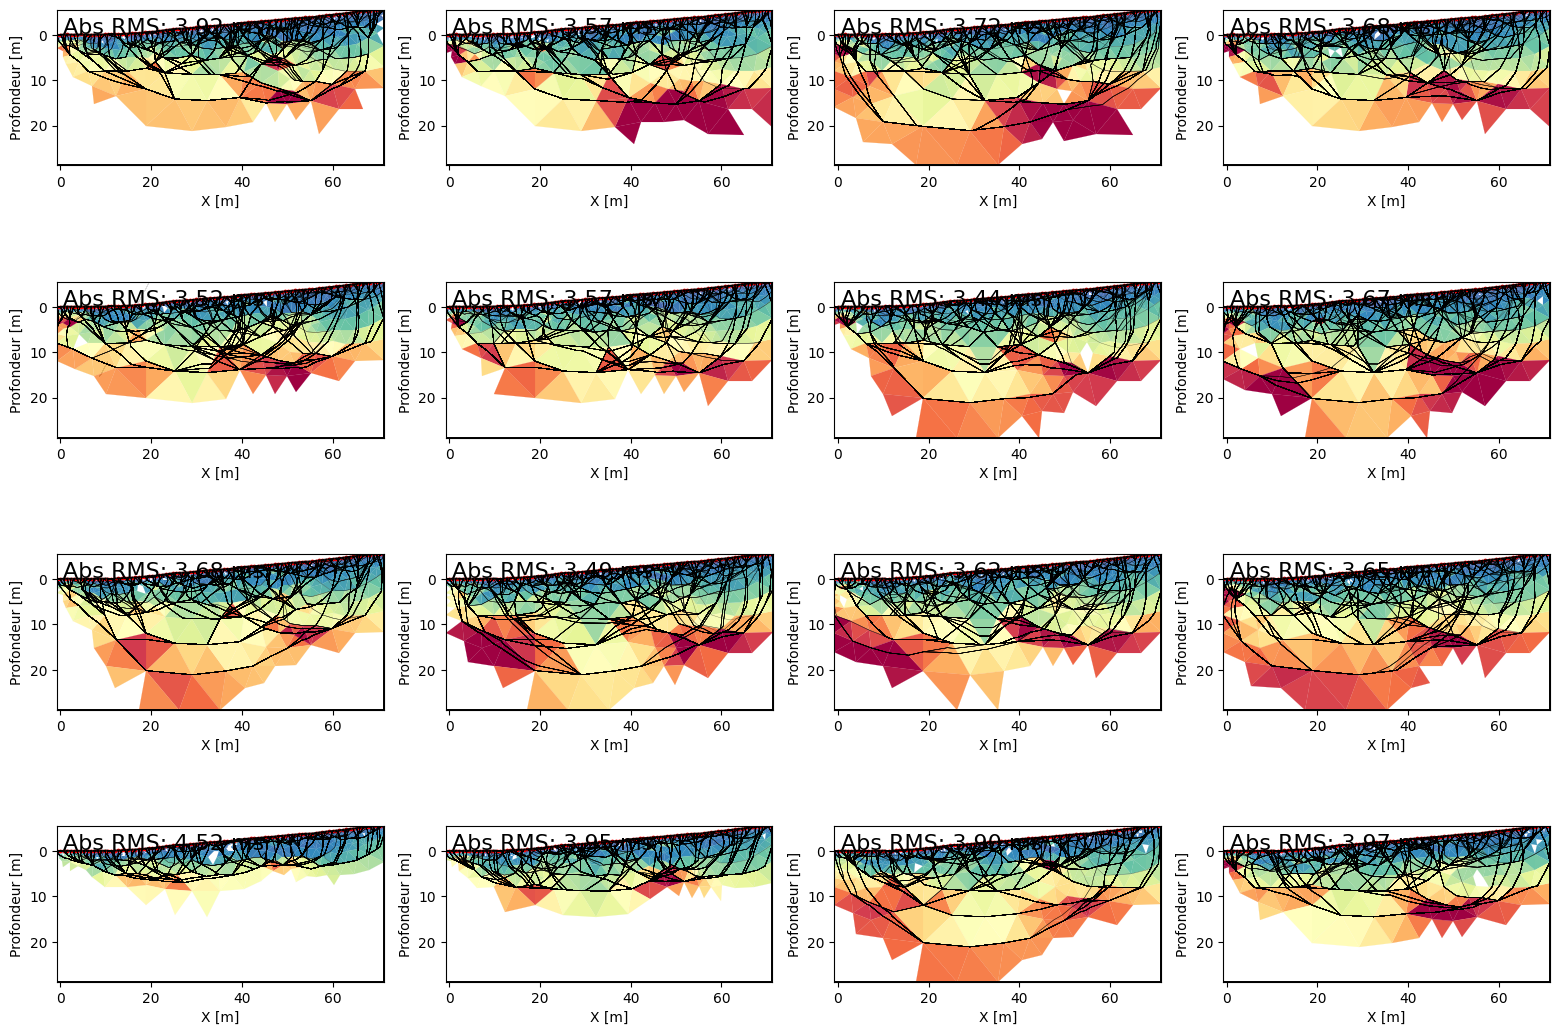

In [11]:
fig, axs = plt.subplots(4, 4, figsize=(16, 14))

abs_rmss = np.zeros(4, 4)

#mgr = tt.TravelTimeManager(data)
for i, vTop in enumerate([10, 50, 100, 1000]):
    for j, vBottom in enumerate([1000, 2000, 3000, 4000]):
        print(i, j)
        
        inv = mgr.invert(secNodes=3, paraMaxCellSize=50.0,
                         zWeight=0.2, vTop=vTop, vBottom=vBottom, verbose=False, usegradient=True, lam=20)
        abs_rms = mgr.inv.absrms() * 1000
        abs_rmss[i, j] = abs_rms
        
        ax = axs[i, j]

        ax, cb = mgr.showResult(ax=ax, logScale=False, nLevs=10, cMap='Spectral_r', colorBar=True, 
                       cMin=10, cMax=4000, orientation='vertical',
                       fitView=True, label='V [m/s]',
                       coverage=mgr.standardizedCoverage(),
                      )
        ax.scatter(data.sensors()[:, 0], data.sensors()[:, 1], s=3, c='r')
        ax.text(0.02, 0.95, f'Abs RMS: {abs_rms:.2f} ms', transform=ax.transAxes, fontsize=10, verticalalignment='top')
        ax.set_xlabel("Х [m]")
        ax.set_ylabel("Profondeur [m]")
        rays = mgr.drawRayPaths(ax=ax, color="k", lw=0.3, alpha=0.5)
        ax.set_title(f'vTop={vTop} vBottom={vBottom}')
        cb.remove()

plt.tight_layout()

<Axes: >

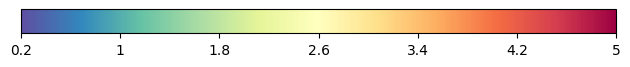

In [46]:
createColorBarOnly(cMin=0.2, cMax=5, logScale=False, cMap='Spectral_r', nLevs=7, orientation='horizontal')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

In [20]:
vel = mgr.paraModel()
t_data = mgr.data('t').array()
t_model = mgr.inv.response.array()
misfit = t_data - t_model
absrms = np.sqrt(np.mean(misfit**2)) # mgr.inv.absrms()
relrms = np.sqrt(np.sum(misfit**2)/np.sum(t_data**2))*100 # relative rms, close to mgr.inv.relrms() TODO what is the exact formula of relrms
chi2 = mgr.inv.chi2()

i_shots = np.array(mgr.data('s'), dtype=int)
i_shots_unique = np.unique(i_shots)
i_geophones = np.array(mgr.data('g'), dtype=int)
i_geophones_unique = np.unique(i_geophones)
x_offset = pg.physics.traveltime.shotReceiverDistances(data, full=True) # full = correction altitude
x, y, z = data.sensorPositions().array().T

rms_shots = []
for k, i_shot in enumerate(i_shots_unique):
    ii = np.where(i_shot == i_shots)
    rms_shot = np.sqrt(np.mean((t_data[ii] - t_model[ii])**2))
    rms_shots.append(rms_shot)
rms_shots = np.array(rms_shots)

rms_geophones = []
for k, i_geophone in enumerate(i_geophones_unique):
    ii = np.where(i_geophone == i_geophones)
    rms_geophone = np.sqrt(np.mean((t_data[ii] - t_model[ii])**2))
    rms_geophones.append(rms_geophone)
rms_geophones = np.array(rms_geophones)

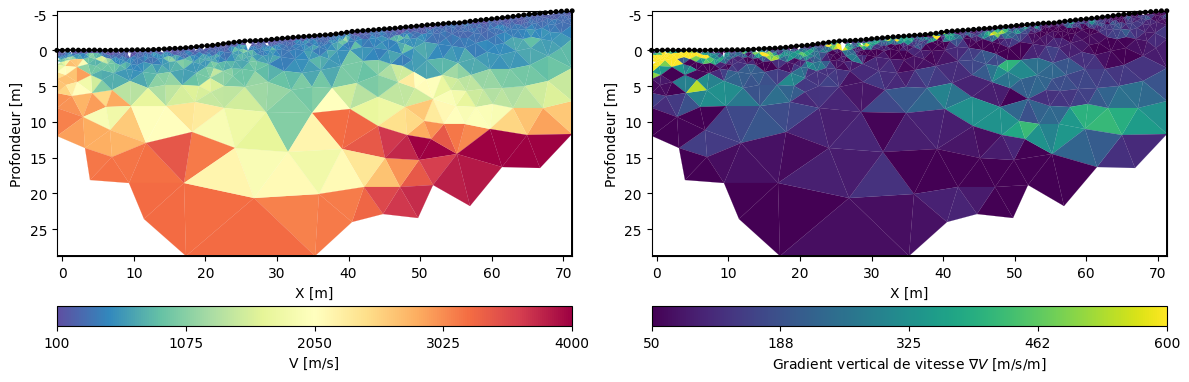

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(12, 8))

ax = axs[0]
pg.show(mgr.mesh, vel, coverage=mgr.standardizedCoverage(), cMin=100, cMax=4000, cMap='Spectral_r', label='V [m/s]', ax=ax)
pg.viewer.mpl.drawSensors(ax, data.sensorPositions(), diam=0.5, color="k")
ax.set_xlabel("Х [m]")
ax.set_ylabel("Profondeur [m]")

ax = axs[1]
vertGrad = pg.solver.grad(mgr.mesh, vel)
pg.show(mgr.mesh, -vertGrad[:,1], coverage=mgr.standardizedCoverage(), cMin=50, cMax=600, cMap='viridis', label='Gradient vertical de vitesse $\\nabla V$ [m/s/m]', ax=ax)
pg.viewer.mpl.drawSensors(ax, data.sensorPositions(), diam=0.5, color="k")
ax.set_xlabel("Х [m]")
ax.set_ylabel("Profondeur [m]")

fig.tight_layout()

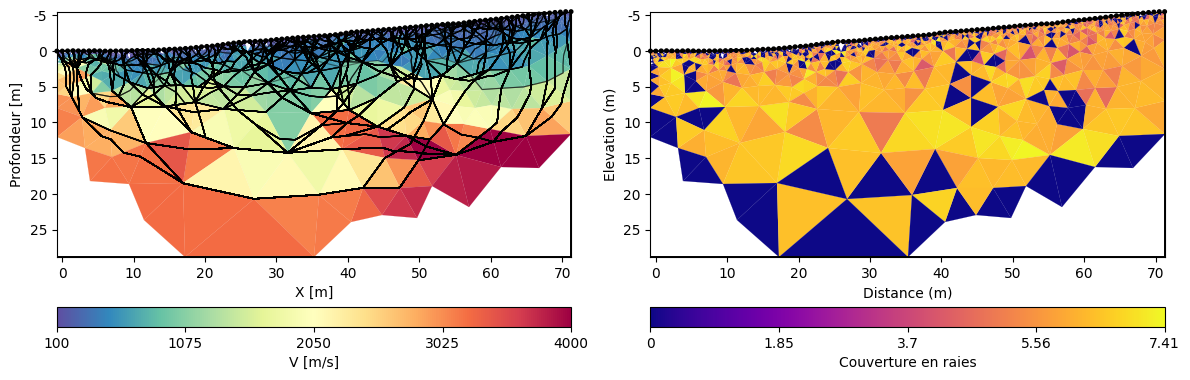

In [26]:
fig, axs = plt.subplots(1, 2, figsize=(12, 8))

ax = axs[0]
pg.show(mgr.mesh, vel, coverage=mgr.standardizedCoverage(), cMin=100, cMax=4000, cMap='Spectral_r', label='V [m/s]', ax=ax)
pg.viewer.mpl.drawSensors(ax, data.sensorPositions(), diam=0.5, color="k")
mgr.drawRayPaths(ax,color="k")
ax.set_xlabel("Х [m]")
ax.set_ylabel("Profondeur [m]")

ax = axs[1]
tmpCov = mgr.coverage()
tmpCov[np.isneginf(tmpCov)] = 0
pg.show(mgr.mesh, data=tmpCov, coverage=mgr.standardizedCoverage(), cMin=0, ax=ax, cMap='plasma', label='Couverture en raies') #cMax=5, 
pg.viewer.mpl.drawSensors(ax, data.sensorPositions(), diam=0.5, color="k")
ax.set_xlabel('Distance (m)')
ax.set_ylabel('Elevation (m)')

fig.tight_layout()

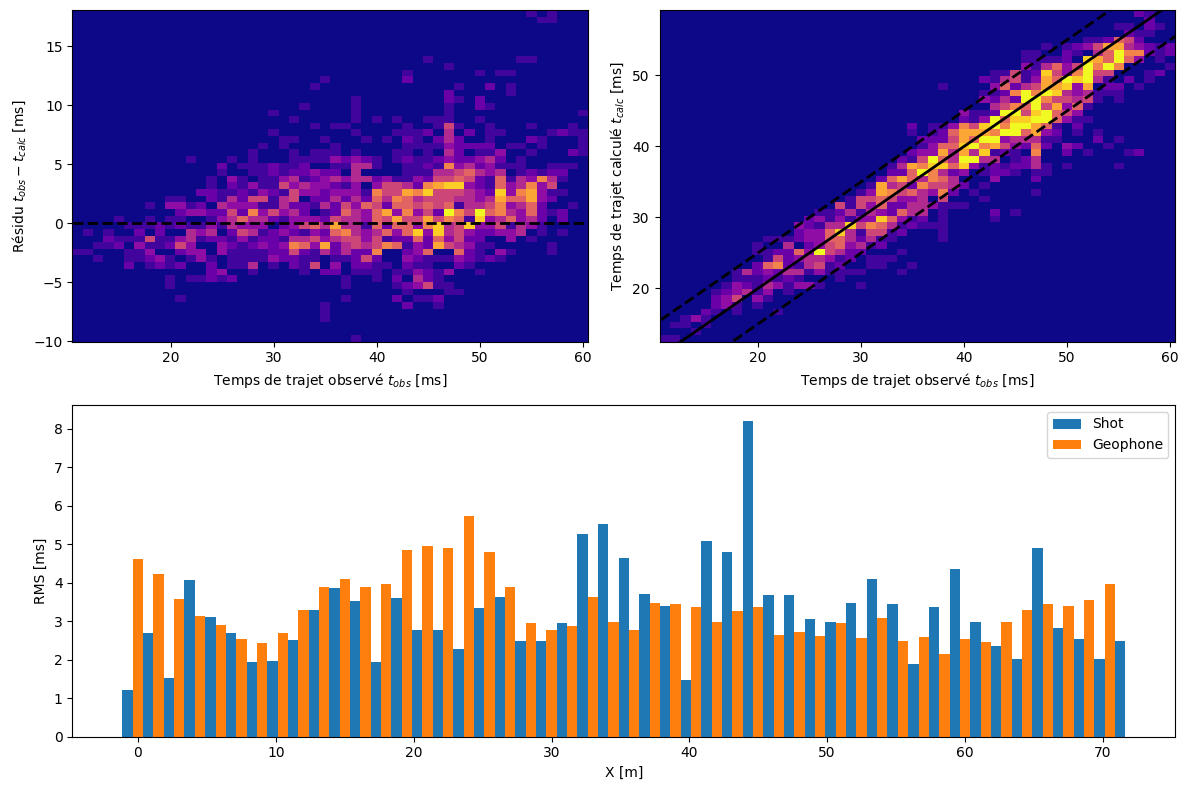

In [27]:
fig, axs = plt.subplot_mosaic("01;22", figsize=(12, 8))
axs = axs['0'], axs['1'], axs['2']

ax = axs[0]
ax.hist2d(t_data*1000, (t_data-t_model)*1000, bins=50, vmin=0,vmax=10,cmap='plasma')
ax.plot([0,200],[0,0],'k--',linewidth=2)
ax.set_xlabel('Temps de trajet observé $t_{obs}$ [ms]')
ax.set_ylabel('Résidu $t_{obs} - t_{calc}$ [ms]')

ax = axs[1]
ax.hist2d(t_data*1000, t_model*1000, bins=50, vmin=0,vmax=10,cmap='plasma')
ax.plot([0,200],[0,200],'k',linewidth=2)
ax.plot([0,200],[-5,195],'k--',linewidth=2)
ax.plot([0,200],[5,205],'k--',linewidth=2)
ax.set_xlabel('Temps de trajet observé $t_{obs}$ [ms]')
ax.set_ylabel('Temps de trajet calculé $t_{calc}$ [ms]')

ax=axs[2]
ax.bar(x[i_shots_unique], rms_shots*1000, width=.75, label='Shot')
ax.bar(x[i_geophones_unique], rms_geophones*1000, width=.75, label='Geophone')
ax.set_xlabel('X [m]')
ax.set_ylabel('RMS [ms]')
ax.legend()

fig.tight_layout()

07/12/24 - 18:39:16 - pyGIMLi - INFO - found 49 x values
07/12/24 - 18:39:16 - pyGIMLi - INFO - found 48 y values
07/12/24 - 18:39:16 - pyGIMLi - INFO - x vector length: 1980
07/12/24 - 18:39:16 - pyGIMLi - INFO - y vector length: 1980
07/12/24 - 18:39:16 - pyGIMLi - INFO - v vector length: 1980
07/12/24 - 18:39:16 - pyGIMLi - INFO - found 49 x values
07/12/24 - 18:39:16 - pyGIMLi - INFO - found 48 y values
07/12/24 - 18:39:16 - pyGIMLi - INFO - x vector length: 1980
07/12/24 - 18:39:16 - pyGIMLi - INFO - y vector length: 1980
07/12/24 - 18:39:16 - pyGIMLi - INFO - v vector length: 1980


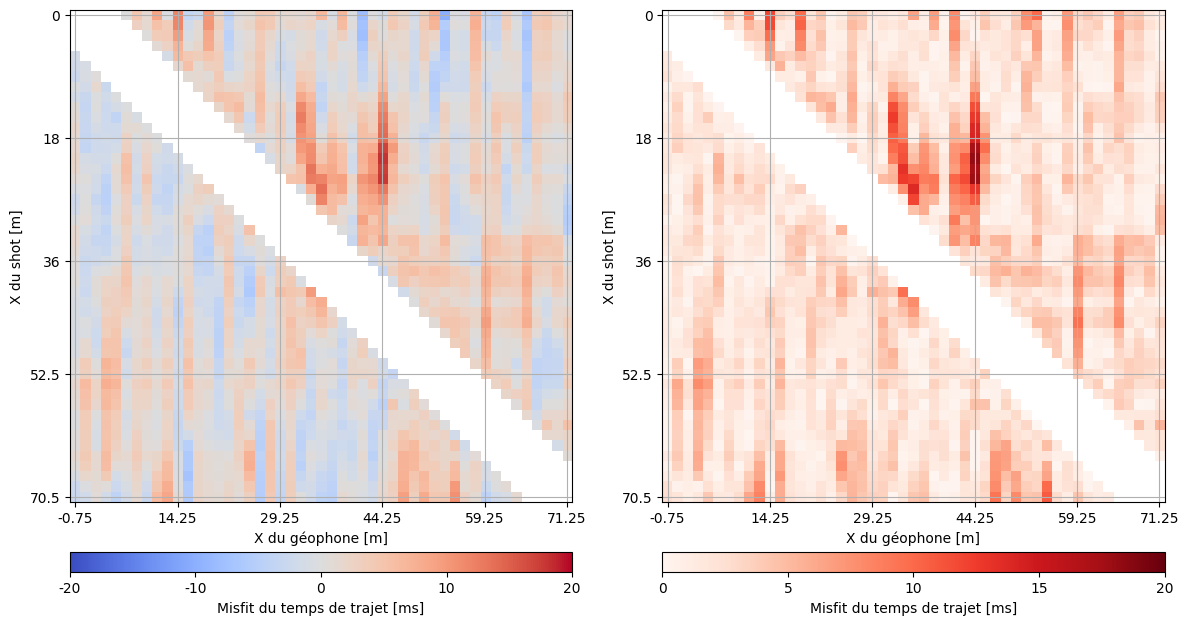

In [28]:
fig, axs = plt.subplots(1, 2, figsize=(12, 8))

ax = axs[0]
ax, _ = pg.viewer.mpl.showDataContainerAsMatrix(data, x[data['s']], x[data['g']], misfit*1000,
                                                cMin=-20, cMax=20,
                                                cMap="coolwarm", full=False,
                                                label="Misfit du temps de trajet [ms]", ax=ax) # cMin=-0.0013, cMax=0.0013, 

ax.set_xlabel('X du géophone [m]')
ax.set_ylabel('X du shot [m]')

ax = axs[1]
ax, _ = pg.viewer.mpl.showDataContainerAsMatrix(data, x[data['s']], x[data['g']], np.abs(misfit)*1000,
                                                cMin=0, cMax=20,
                                                cMap="Reds", full=False,
                                                label="Misfit du temps de trajet [ms]", ax=ax) # cMin=-0.0013, cMax=0.0013, 

ax.set_xlabel('X du géophone [m]')
ax.set_ylabel('X du shot [m]')

fig.tight_layout()

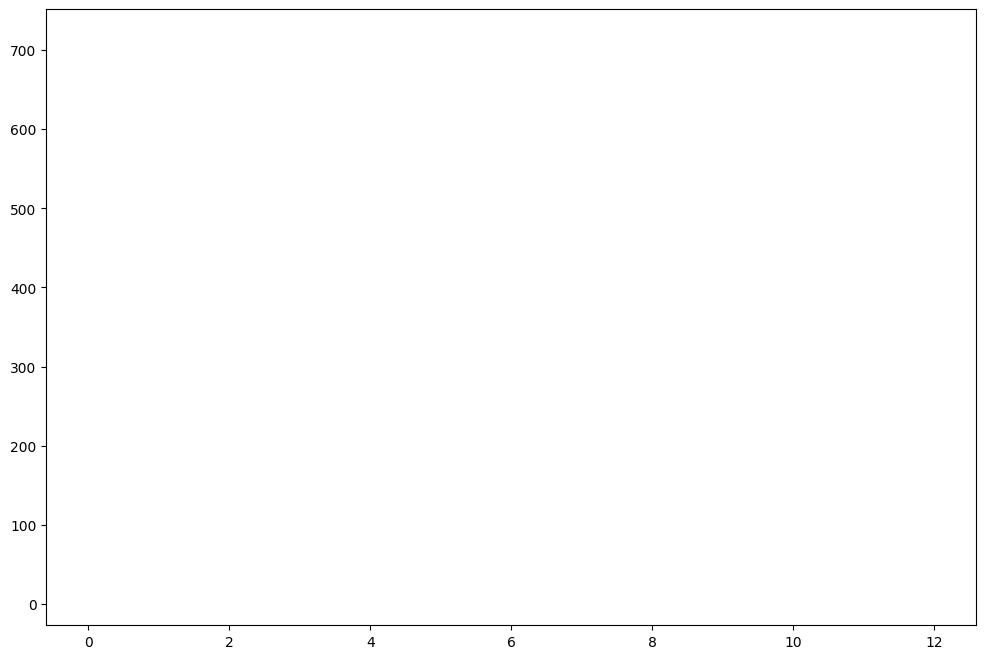

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

for k, model in enumerate(mgr.inv.modelHistory):
    # TODO compute RMS and misfit for each iteration (cost function)
    ax.plot(k, mgr.inv.chi2History[k])

In [30]:
inv = mgr.createInversionFramework() # inv =
RM, RD = resolutionMatrix(inv, returnRD=True)

Text(0.5, 1.0, 'Modèle')

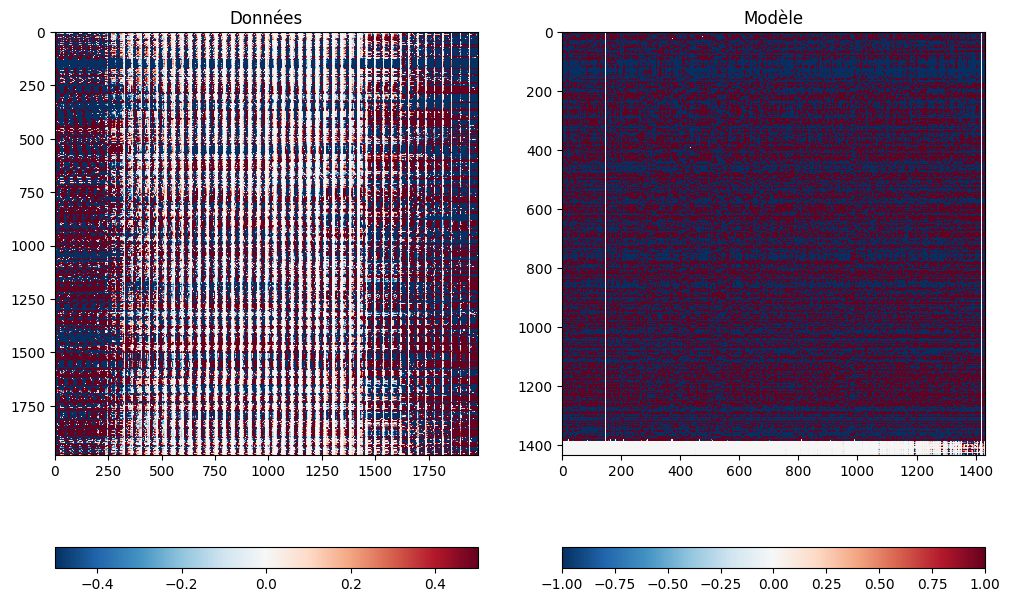

In [31]:
fig, axs = plt.subplots(1, 2, figsize=(12, 8))

ax = axs[0]
im = ax.imshow(RD, cmap="RdBu_r", vmin=-0.5, vmax=.5)
cb = fig.colorbar(im, location='bottom')
ax.set_title('Données')

ax = axs[1]
im = plt.imshow(RM, cmap="RdBu_r", vmin=-1, vmax=1)
cb = fig.colorbar(im, location='bottom')
ax.set_title('Modèle')

(<Axes: xlabel='$x$ in m', ylabel='Depth in m'>,
 <matplotlib.colorbar.Colorbar at 0x7f8d89e9fc10>)

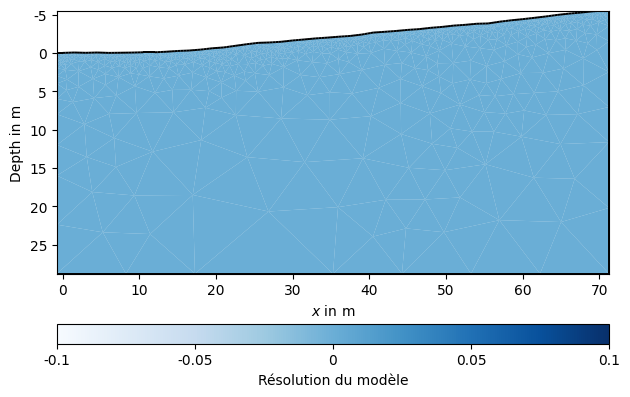

In [32]:
pg.show(mgr.paraDomain, RM[:, 0], label='Résolution du modèle', cMap='Blues', vmin=0, vmax=10)

In [ ]:
## TODO
# retirer points 4m
# attention au plancher a 25m peut etre artéfact
# comparer inversions différentes régularisations
# comparer différents modèles initiaux
# damier